# V - Calculating areas of change and confidence intervals
### This script serves to perform a quick estimation of areas and confidence intervals for all types of change using validated data
### This script requires a m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker

### 1 - Read files and set parameters

In [ ]:
z_score = 1.647

In [2]:
def calculate_areas(df_merged, kozak_column, target_column, total_area):
    
    df_full = df_merged.copy()
    df_merged = df_merged[df_merged['interpreted'] == 1]
    
    # get all attributes
    categories = df_merged[target_column].unique()
    print(categories)
    # get strata
    strata, d = df_merged[kozak_column].unique(), {}
    
    # create stats for each entry
    for category in categories:
        
        if str(category) == 'nan':
            continue
            
        print(f' Calculating stats for {category}')
        # create binary class column
        df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)
        print(f'There are {df_merged[category].sum()} entries of {category} in {target_column}.')
        
        # initialize variables for category
        categories_area, se_total = 0, 0
        d2 = {}
        for stratum in strata:
                        
            if str(stratum) == 'nan':
                continue
            
            # subset to stratum
            strat_df = df_full[df_full[kozak_column] == stratum]
            
            # get area proportion for that stratum on full dataset
            proportion_strata = len(strat_df)/len(df_full)

            # get stratum area
            stratum_area = proportion_strata * total_area

            # get proportion of forest change within strata from interpreted data
            proportion_category = len(
                df_merged[(df_merged[kozak_column] == stratum) & (df_merged[category] == 1)]
            ) / len(
                df_merged[df_merged[kozak_column] == stratum]
            )
            
            # get area from proportion and full area
            area = proportion_category * stratum_area

            # get error from interpreted data for full stratum area
            var = np.var(df_merged[category][df_merged[kozak_column] == stratum]) / len(df_merged[df_merged[kozak_column] == stratum])
            se = np.sqrt(var) * stratum_area

            # add for totals
            categories_area += area
            se_total += se**2
            
            # add to dictionary
            d2[f'area_stratum_{stratum}'] = area
            d2[f'ci_stratum_{stratum}']=1.67*se
        
        d2['area_total'] = categories_area
        d2['ci_total'] = z_score*np.sqrt(se_total)
        d2['perc_error'] = np.sqrt(se_total) / categories_area * 100
        d[category] = d2
    
    
    return pd.DataFrame.from_dict(d, orient='index')

### read the output merged file from the previous script

In [3]:
#DRC
#df = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_ceo_merge.csv', low_memory=False)
#GAB
df = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_ceo_merge.csv', low_memory=False)

In [4]:
print(df.columns.values)

['images' 'mon_images' 'bfast_change_date' 'bfast_magnitude' 'bfast_means'
 'cusum_change_date' 'cusum_confidence' 'cusum_magnitude' 'red_mean'
 'red_sd' 'red_min' 'red_max' 'nir_mean' 'nir_sd' 'nir_min' 'nir_max'
 'swir1_mean' 'swir1_sd' 'swir1_min' 'swir1_max' 'swir2_mean' 'swir2_sd'
 'swir2_min' 'swir2_max' 'ndfi_mean' 'ndfi_sd' 'ndfi_min' 'ndfi_max'
 'brightness_mean' 'brightness_sd' 'brightness_min' 'brightness_max'
 'greenness_mean' 'greenness_sd' 'greenness_min' 'greenness_max'
 'wetness_mean' 'wetness_sd' 'wetness_min' 'wetness_max' 'bs_slope_mean'
 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'esri_lc18' 'esri_lc19'
 'esri_lc20' 'esri_lc21' 'gfc_gain' 'gfc_loss' 'gfc_lossyear' 'gfc_tc00'
 'lang_tree_height' 'potapov_tree_height' 'slope' 'tmf_2016' 'tmf_2017'
 'tmf_2018' 'tmf_2019' 'tmf_20

In [5]:
print(len(df))

222878


In [7]:
value_counts = df['Ref_Change_Year_1522'].value_counts().sort_index()
print(value_counts)

Def2016      21
Def2017      13
Def2018       7
Def2019       2
Def2020       6
Def2021       7
Def2022      13
Deg2016      14
Deg2017      14
Deg2018      23
Deg2019      16
Deg2020      26
Deg2021      22
Deg2022      37
NF         1204
Stable     4621
Name: Ref_Change_Year_1522, dtype: int64


#### enter area of study in ha calculated in GIS or from LSIB for country or area of interest

In [8]:
#DRC forest mask applied
#study_area = 62009300
#CMR forest mask applied
#study_area = 39709141
#GAB
study_area = 26287600
#EQG
#study_area = 2685800
#COG
#study_area = 25361094
#CAR forest mask applied
#study_area = 58889539


### calculate for all years

In [21]:
interpreted = [
    'Def2016', 'Def2017', 'Def2018', 'Def2019', 'Def2020', 'Def2021', 'Def2022',
    'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020', 'Deg2021',
    'Deg2022', 'NF', 'Stable'
]

#df['interpreted'] = df['ChangeYear'].apply(lambda x: 1 if str(x) in interpreted else 0)
df['accumulated'] = df['Ref_Change_Year_1522'].apply(
    lambda x: 'Deforestation' if str(x).startswith('Def') else 'Degradation' if str(x).startswith('Deg') else 'Stable' if str(x).startswith('Sta') else 'NF'if str(x).startswith('NF') else "0")
stats_gdf = calculate_areas(df, 'stratum', 'accumulated', study_area).sort_index()

['Stable' 'NF' 'Degradation' 'Deforestation']
 Calculating stats for Stable
There are 4621 entries of Stable in accumulated.
 Calculating stats for NF
There are 1204 entries of NF in accumulated.


/tmp/ipykernel_684/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Degradation
There are 152 entries of Degradation in accumulated.
 Calculating stats for Deforestation
There are 69 entries of Deforestation in accumulated.


/tmp/ipykernel_684/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)
/tmp/ipykernel_684/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


In [22]:
np.unique(df['accumulated'], return_counts=True)

(array(['0', 'Deforestation', 'Degradation', 'NF', 'Stable'], dtype=object),
 array([216832,     69,    152,   1204,   4621]))

In [23]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
stats_gdf[['area_total', 'ci_total', 'perc_error']]
stats_gdf['ChangeYear'] = stats_gdf.index

In [25]:
stats_gdf

,area_stratum_1,ci_stratum_1,area_stratum_2,ci_stratum_2,area_stratum_3,ci_stratum_3,area_total,ci_total,perc_error,ChangeYear
Deforestation,37427.183,36053.210,16901.809,8909.841,40969.632,8983.694,95298.624,38208.978,24.008,Deforestation
Degradation,49902.911,41617.897,47325.065,14860.671,87792.068,12879.253,185020.044,46030.034,14.897,Degradation
NF,1759077.619,236480.751,1091856.850,62889.219,305077.438,21504.365,3156011.906,245643.313,4.661,NF
Stable,18538931.502,241711.102,3559520.938,64136.431,752816.986,23697.368,22851269.425,251195.748,0.658,Stable


### calculate for each year

In [16]:
interpreted = [
    'Def2016', 'Def2017', 'Def2018', 'Def2019', 'Def2020', 'Def2021', 'Def2022',
    'Deg2016', 'Deg2017', 'Deg2018', 'Deg2019', 'Deg2020', 'Deg2021',
    'Deg2022', 'NF', 'Stable'
]

df['interpreted'] = df['Ref_Change_Year_1522'].apply(lambda x: 1 if str(x) in interpreted else 0)
#df['accumulated'] = df['ChangeYear'].apply(
#    lambda x: 'Deforestation' if str(x).startswith('Def') else 'Degradation' if str(x).startswith('Deg') else 'Stable' if str(x).startswith('Sta') else 'NF')

stats_df = calculate_areas(df, 'stratum', 'Ref_Change_Year_1522', study_area).sort_index()

['Stable' 'NF' 'Deg2021' 'Deg2019' 'Deg2018' 'Def2016' 'Def2022' 'Def2020'
 'Deg2022' 'Deg2016' 'Deg2020' 'Def2017' 'Deg2017' 'Def2021' 'Def2018'
 'Def2019']
 Calculating stats for Stable
There are 4621 entries of Stable in Ref_Change_Year_1522.
 Calculating stats for NF
There are 1204 entries of NF in Ref_Change_Year_1522.


/tmp/ipykernel_684/3839375425.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged[category] = df_merged[target_column].apply(lambda x: 1 if x == category else 0)


 Calculating stats for Deg2021
There are 22 entries of Deg2021 in Ref_Change_Year_1522.
 Calculating stats for Deg2019
There are 16 entries of Deg2019 in Ref_Change_Year_1522.
 Calculating stats for Deg2018
There are 23 entries of Deg2018 in Ref_Change_Year_1522.
 Calculating stats for Def2016
There are 21 entries of Def2016 in Ref_Change_Year_1522.
 Calculating stats for Def2022
There are 13 entries of Def2022 in Ref_Change_Year_1522.
 Calculating stats for Def2020
There are 6 entries of Def2020 in Ref_Change_Year_1522.
 Calculating stats for Deg2022
There are 37 entries of Deg2022 in Ref_Change_Year_1522.
 Calculating stats for Deg2016
There are 14 entries of Deg2016 in Ref_Change_Year_1522.
 Calculating stats for Deg2020
There are 26 entries of Deg2020 in Ref_Change_Year_1522.
 Calculating stats for Def2017
There are 13 entries of Def2017 in Ref_Change_Year_1522.
 Calculating stats for Deg2017
There are 14 entries of Deg2017 in Ref_Change_Year_1522.
 Calculating stats for Def2021
Th

In [17]:
stats_df

,area_stratum_1,ci_stratum_1,area_stratum_2,ci_stratum_2,area_stratum_3,ci_stratum_3,area_total,ci_total,perc_error
Def2016,0.000,0.000,3380.362,3990.331,13900.411,5294.301,17280.773,6629.658,22.973
Def2017,0.000,0.000,5070.543,4886.261,7316.006,3851.657,12386.548,6221.801,30.078
Def2018,0.000,0.000,0.000,0.000,5121.204,3225.525,5121.204,3225.525,37.715
Def2019,0.000,0.000,0.000,0.000,1463.201,1726.782,1463.201,1726.782,70.667
Def2020,0.000,0.000,3380.362,3990.331,2926.402,2440.531,6306.764,4677.492,44.411
Def2021,0.000,0.000,3380.362,3990.331,3658.003,2727.753,7038.365,4833.568,41.123
Def2022,37427.183,36053.210,1690.181,2822.096,6584.405,3655.136,45701.769,36347.740,47.624
Deg2016,0.000,0.000,5070.543,4886.261,8047.606,4038.399,13118.149,6339.102,28.936
Deg2017,0.000,0.000,1690.181,2822.096,9510.807,4387.476,11200.988,5216.721,27.888
Deg2018,0.000,0.000,3380.362,3990.331,15363.612,5562.505,18743.974,6845.743,21.870


In [18]:
stats_df['ChangeYear'] = stats_df.index
#stats_df
stats_df.columns

Index(['area_stratum_1', 'ci_stratum_1', 'area_stratum_2', 'ci_stratum_2',
       'area_stratum_3', 'ci_stratum_3', 'area_total', 'ci_total',
       'perc_error', 'ChangeYear'],
      dtype='object')

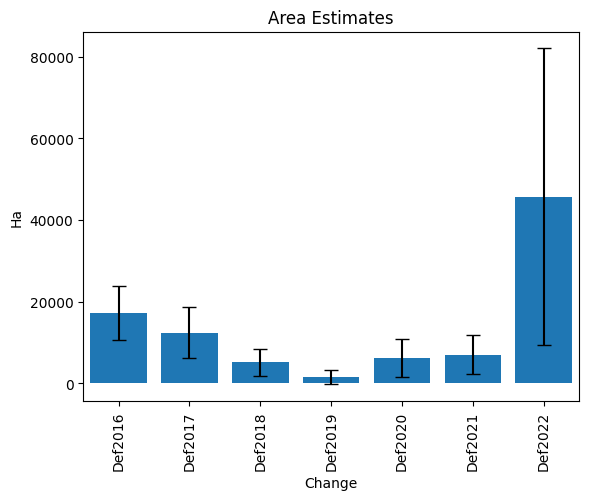

In [19]:
#plot DEF 
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
Def_areas = stats_df[stats_df['ChangeYear'].isin(values_to_plot)]

# Create a bar chart
ax = Def_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Def_areas['ChangeYear'], Def_areas['area_total'], yerr=Def_areas['ci_total'], capsize=5)  # Add error bars

# Show the plot
plt.show()

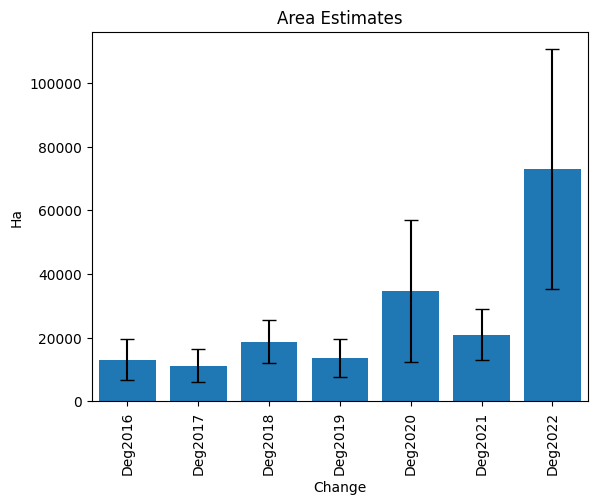

In [20]:
#plot DEG 
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
Deg_areas = stats_df[stats_df['ChangeYear'].isin(values_to_plot)]

# Create a bar chart
ax = Deg_areas.plot(kind='bar', x='ChangeYear', y='area_total', legend=False)

# Format the y-axis labels with thousand separators (comma)
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{:,.0f}'))

# Add labels and a title
plt.xlabel('Change')
plt.ylabel('Ha')
plt.title('Area Estimates')
plt.bar(Deg_areas['ChangeYear'], Deg_areas['area_total'], yerr=Deg_areas['ci_total'], capsize=5)  # Add error bars
# Show the plot
plt.show()

### export stats to csv

In [ ]:
grouped_out =  '/home/sepal-user/module_results/esbae/GAB/GAB_total_stats_2015_2022.csv'
stats_gdf.to_csv(grouped_out,index=True)

In [ ]:
annual_out =  '/home/sepal-user/module_results/esbae/GAB/GAB_annual_stats_2015_2022.csv'
stats_df.to_csv(annual_out,index=True)